## **Introduction**

This notebook is designed to perform statistical tests to evaluate the impact of image layout, CTA and social proof assignments on key metrics - conversion rate and revenue. We use both frequentist and Bayesian approaches.

## **Hypotheses**



**Hypothesis 1: Product Image Layout Impact**

H0: Different product image layouts (single large vs. gallery grid) have no effect on conversion rate

H1: Gallery grid layout increases conversion rate by at least 15%

Rationale: Visual presentation directly impacts purchase decisions

**Hypothesis 2: Call-to-Action Button Optimization**

H0: Button color and text changes don't affect click-through rate

H1: Red "Buy Now" button outperforms blue "Add to Cart" by 10%+ CTR

Rationale: Urgency language and color
psychology influence user behavior

**Hypothesis 3: Social Proof Integration**

H0: Adding customer reviews and ratings doesn't impact conversion

H1: Displaying reviews increases conversion rate by 20%+

Rationale: Social proof reduces purchase anxiety

## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, norm, beta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import ttest_power, zt_ind_solve_power
import warnings
warnings.filterwarnings('ignore')

## **Class Definition for A/B Analysis**

In [ ]:
class ABTestAnalyzer:
    """
    Comprehensive A/B testing statistical analysis framework
    """

    def __init__(self, alpha=0.05, power=0.8):
        self.alpha = alpha
        self.power = power
        self.results = {}

    def power_analysis(self, baseline_rate, effect_size, sample_size=None):
        """
        Calculate statistical power or required sample size
        """
        if sample_size is None:
            # Calculate required sample size
            required_n = zt_ind_solve_power(
                effect_size=effect_size,
                power=self.power,
                alpha=self.alpha,
                ratio=1.0  # Equal group sizes
            )
            return int(np.ceil(required_n))
        else:
            # Calculate achieved power
            achieved_power = zt_ind_solve_power(
                effect_size=effect_size,
                nobs1=sample_size,
                alpha=self.alpha,
                ratio=1.0
            )
            return achieved_power

    def proportion_test(self, data, group_col, metric_col, test_name):
        """
        Two-proportion z-test for conversion rates
        """
        # Group data
        control_data = data[data[group_col] == 'control'][metric_col]
        treatment_data = data[data[group_col] == 'treatment'][metric_col]

        # Calculate counts and sample sizes
        control_successes = control_data.sum()
        control_n = len(control_data)
        treatment_successes = treatment_data.sum()
        treatment_n = len(treatment_data)

        # Conversion rates
        control_rate = control_successes / control_n
        treatment_rate = treatment_successes / treatment_n

        # Two-proportion z-test
        counts = np.array([control_successes, treatment_successes])
        nobs = np.array([control_n, treatment_n])

        z_stat, p_value = proportions_ztest(counts, nobs)

        # Confidence intervals
        control_ci = proportion_confint(control_successes, control_n, alpha=self.alpha)
        treatment_ci = proportion_confint(treatment_successes, treatment_n, alpha=self.alpha)

        # Effect size calculations
        pooled_rate = (control_successes + treatment_successes) / (control_n + treatment_n)
        pooled_se = np.sqrt(pooled_rate * (1 - pooled_rate) * (1/control_n + 1/treatment_n))

        relative_lift = (treatment_rate - control_rate) / control_rate
        absolute_lift = treatment_rate - control_rate

        # Statistical significance
        is_significant = p_value < self.alpha


        results = {
            'test_name': test_name,
            'metric': metric_col,
            'control_rate': control_rate,
            'treatment_rate': treatment_rate,
            'control_ci_lower': control_ci[0],
            'control_ci_upper': control_ci[1],
            'treatment_ci_lower': treatment_ci[0],
            'treatment_ci_upper': treatment_ci[1],
            'control_n': control_n,
            'treatment_n': treatment_n,
            'z_statistic': z_stat,
            'p_value': p_value,
            'is_significant': is_significant,
            'relative_lift': relative_lift,
            'absolute_lift': absolute_lift,
            'pooled_se': pooled_se
        }

        return results

    def continuous_metric_test(self, data, group_col, metric_col, test_name):
        """
        T-test for continuous metrics (e.g., revenue per user)
        """
        control_data = data[data[group_col] == 'control'][metric_col]
        treatment_data = data[data[group_col] == 'treatment'][metric_col]

        # Remove outliers (optional)
        control_clean = self._remove_outliers(control_data)
        treatment_clean = self._remove_outliers(treatment_data)

        # T-test
        t_stat, p_value = ttest_ind(treatment_clean, control_clean, equal_var=False)

        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(control_clean) - 1) * control_clean.var() +
                            (len(treatment_clean) - 1) * treatment_clean.var()) /
                           (len(control_clean) + len(treatment_clean) - 2))
        cohens_d = (treatment_clean.mean() - control_clean.mean()) / pooled_std

        # Confidence intervals for means
        control_ci = stats.t.interval(
            1 - self.alpha, len(control_clean) - 1,
            loc=control_clean.mean(),
            scale=stats.sem(control_clean)
        )

        treatment_ci = stats.t.interval(
            1 - self.alpha, len(treatment_clean) - 1,
            loc=treatment_clean.mean(),
            scale=stats.sem(treatment_clean)
        )

        absolute_lift = treatment_clean.mean() - control_clean.mean()
        pooled_se = pooled_std * np.sqrt(1/len(control_clean) + 1/len(treatment_clean))

        results = {
            'test_name': test_name,
            'metric': metric_col,
            'control_rate': control_clean.mean(),
            'treatment_rate': treatment_clean.mean(),
            'control_std': control_clean.std(),
            'treatment_std': treatment_clean.std(),
            'control_ci_lower': control_ci[0],
            'control_ci_upper': control_ci[1],
            'treatment_ci_lower': treatment_ci[0],
            'treatment_ci_upper': treatment_ci[1],
            'control_n': len(control_clean),
            'treatment_n': len(treatment_clean),
            'z_statistic': t_stat,
            'p_value': p_value,
            'is_significant': p_value < self.alpha,
            'cohens_d': cohens_d,
            'relative_lift': (treatment_clean.mean() - control_clean.mean()) / control_clean.mean(),
            'absolute_lift': absolute_lift,
            'pooled_se': pooled_se
        }

        return results

    def bayesian_analysis(self, data, group_col, metric_col, test_name, n_simulations=10000):
        """
        Bayesian A/B test analysis using Beta-Binomial model
        """
        control_data = data[data[group_col] == 'control'][metric_col]
        treatment_data = data[data[group_col] == 'treatment'][metric_col]

        # Prior parameters (weak priors)
        alpha_prior = 1
        beta_prior = 1

        # Posterior parameters
        control_successes = control_data.sum()
        control_failures = len(control_data) - control_successes
        treatment_successes = treatment_data.sum()
        treatment_failures = len(treatment_data) - treatment_successes

        control_alpha_post = alpha_prior + control_successes
        control_beta_post = beta_prior + control_failures
        treatment_alpha_post = alpha_prior + treatment_successes
        treatment_beta_post = beta_prior + treatment_failures

        # Generate posterior samples
        control_samples = np.random.beta(control_alpha_post, control_beta_post, n_simulations)
        treatment_samples = np.random.beta(treatment_alpha_post, treatment_beta_post, n_simulations)

        # Calculate probability that treatment > control
        prob_treatment_better = np.mean(treatment_samples > control_samples)

        # Credible intervals
        control_ci = np.percentile(control_samples, [2.5, 97.5])
        treatment_ci = np.percentile(treatment_samples, [2.5, 97.5])

        # Expected lift
        lift_samples = (treatment_samples - control_samples) / control_samples
        expected_lift = np.mean(lift_samples)
        lift_ci = np.percentile(lift_samples, [2.5, 97.5])

        results = {
            'test_name': test_name,
            'metric': metric_col,
            'prob_treatment_better': prob_treatment_better,
            'control_rate_mean': np.mean(control_samples),
            'treatment_rate_mean': np.mean(treatment_samples),
            'control_ci_lower': control_ci[0],
            'control_ci_upper': control_ci[1],
            'treatment_ci_lower': treatment_ci[0],
            'treatment_ci_upper': treatment_ci[1],
            'expected_lift': expected_lift,
            'lift_ci_lower': lift_ci[0],
            'lift_ci_upper': lift_ci[1],
            'bayesian_significant': prob_treatment_better > 0.95
        }

        return results

    def sequential_testing(self, data, group_col, metric_col, test_name,
                          alpha_spending_func='obrien_fleming'):
        """
        Sequential testing with alpha spending function
        """
        # Sort data by date
        data_sorted = data.sort_values('session_date')

        # Calculate cumulative results over time
        results_over_time = []

        # Minimum sample size before testing
        min_sample_size = 1000

        for i in range(min_sample_size, len(data_sorted), 100):  # Check every 100 samples
            current_data = data_sorted.iloc[:i]

            # Run proportion test
            current_result = self.proportion_test(current_data, group_col, metric_col, test_name)

            # Calculate adjusted alpha for sequential testing
            information_fraction = i / len(data_sorted)
            adjusted_alpha = self._alpha_spending(information_fraction, alpha_spending_func)

            current_result['sample_size'] = i
            current_result['information_fraction'] = information_fraction
            current_result['adjusted_alpha'] = adjusted_alpha
            current_result['sequential_significant'] = current_result['p_value'] < adjusted_alpha

            results_over_time.append(current_result)

            # Early stopping if significant
            if current_result['sequential_significant']:
                break

        return pd.DataFrame(results_over_time)

    def _alpha_spending(self, information_fraction, func_type='obrien_fleming'):
        """Alpha spending function for sequential testing"""
        if func_type == 'obrien_fleming':
            return 2 * (1 - stats.norm.cdf(stats.norm.ppf(1 - self.alpha/2) / np.sqrt(information_fraction)))
        elif func_type == 'pocock':
            return self.alpha * np.log(1 + (np.e - 1) * information_fraction)
        else:
            return self.alpha  # No adjustment

    def segmentation_analysis(self, data, group_col, metric_col, segment_col, test_name):
        """
        Analyze treatment effects across different segments
        """
        segments = data[segment_col].unique()
        segment_results = []

        for segment in segments:
            segment_data = data[data[segment_col] == segment]

            if len(segment_data) < 100:  # Skip small segments
                continue

            result = self.proportion_test(segment_data, group_col, metric_col, f"{test_name}_{segment}")
            result['segment'] = segment
            result['segment_type'] = segment_col
            segment_results.append(result)

        return pd.DataFrame(segment_results)

    def cohort_analysis(self, data, group_col, metric_col, date_col, test_name):
        """
        Analyze treatment effects over time (cohort analysis)
        """
        data['week'] = data[date_col].dt.isocalendar().week
        weeks = sorted(data['week'].unique())

        cohort_results = []

        for week in weeks:
            week_data = data[data['week'] == week]

            if len(week_data) < 100:  # Skip weeks with insufficient data
                continue

            result = self.proportion_test(week_data, group_col, metric_col, f"{test_name}_week_{week}")
            result['week'] = week
            cohort_results.append(result)

        return pd.DataFrame(cohort_results)

    def multiple_testing_correction(self, results_df, method='bonferroni'):
        """
        Apply multiple testing correction
        """
        from statsmodels.stats.multitest import multipletests

        p_values = results_df['p_value'].values

        if method == 'bonferroni':
            rejected, p_adjusted, _, _ = multipletests(p_values, alpha=self.alpha, method='bonferroni')
        elif method == 'fdr':
            rejected, p_adjusted, _, _ = multipletests(p_values, alpha=self.alpha, method='fdr_bh')
        else:
            rejected, p_adjusted = p_values < self.alpha, p_values

        results_df['p_value_adjusted'] = p_adjusted
        results_df['significant_adjusted'] = rejected

        return results_df

    def _remove_outliers(self, data, method='iqr', multiplier=1.5):
        """Remove outliers using IQR method"""

        if data.name in ['revenue', 'log_revenue']:
          print(f"[Info]: Skipping outlier removal for metric {data.name}.")
          return data

        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        cleaned =  data[(data >= lower_bound) & (data <= upper_bound)]

        if len(cleaned) < 0.5 * len(data):
          print("[Warning]: Skipping Outlier removal for skewed metric.")
          return data
        return cleaned

    def run_complete_analysis(self, data, test_configs):
        """
        Run complete A/B testing analysis for all tests

        test_configs: list of dictionaries with keys:
        - test_name: name of the test
        - group_col: column name for treatment groups
        - metrics: list of metrics to analyze
        """

        all_results = {
            'frequentist': [],
            'bayesian': [],
            'sequential': [],
            'segmentation': [],
            'cohort': []
        }

        for config in test_configs:
            test_name = config['test_name']
            group_col = config['group_col']
            metrics = config['metrics']

            print(f"\nAnalyzing {test_name}...")

            for metric in metrics:
                print(f"  - {metric}")

                # Decide which test to run based on data type
                if pd.api.types.is_bool_dtype(data[metric]) or pd.api.types.is_integer_dtype(data[metric]):
                      # Binary metrics
                      freq_result = self.proportion_test(data, group_col, metric, test_name)
                      all_results['frequentist'].append(freq_result)

                      # Bayesian only for binary
                      bayes_result = self.bayesian_analysis(data, group_col, metric, test_name)
                      all_results['bayesian'].append(bayes_result)

                elif pd.api.types.is_float_dtype(data[metric]):
                      # Continuous metrics
                      freq_result = self.continuous_metric_test(data, group_col, metric, test_name)
                      all_results['frequentist'].append(freq_result)



                # Sequential testing
                seq_results = self.sequential_testing(data, group_col, metric, test_name)
                all_results['sequential'].append(seq_results)

                # Segmentation analysis
                for segment_col in ['device_type', 'traffic_source', 'user_type']:
                    seg_results = self.segmentation_analysis(data, group_col, metric, segment_col, test_name)
                    all_results['segmentation'].append(seg_results)

                # Cohort analysis
                cohort_results = self.cohort_analysis(data, group_col, metric, 'session_date', test_name)
                all_results['cohort'].append(cohort_results)

        # Convert to DataFrames

        for key in all_results:
            if key in ['sequential', 'segmentation', 'cohort']:
                if all_results[key]:
                    all_results[key] = pd.concat(all_results[key], ignore_index=True)
                else:
                    all_results[key] = pd.DataFrame()
            else:
                all_results[key] = pd.DataFrame(all_results[key])

        freq_df = pd.DataFrame(all_results['frequentist'])

         # Standardize column names if needed
        if 'control_mean' in freq_df.columns:
          freq_df['control_rate'] = freq_df['control_mean']
          freq_df['treatment_rate'] = freq_df['treatment_mean']

        if 't_statistic' in freq_df.columns:
          freq_df['z_statistic'] = freq_df['t_statistic']




        # Apply multiple testing correction
        if len(all_results['frequentist']) > 0:
            all_results['frequentist'] = self.multiple_testing_correction(
                all_results['frequentist'], method='fdr'
            )

        self.results = all_results
        return all_results

    def generate_summary_report(self):
        """Generate a summary report of all test results"""

        if not self.results:
            return "No analysis results available. Run analysis first."

        report = []
        report.append("=" * 60)
        report.append("A/B TESTING ANALYSIS SUMMARY REPORT")
        report.append("=" * 60)

        # Frequentist results summary
        freq_results = self.results['frequentist']
        if len(freq_results) > 0:
            report.append("\nFREQUENTIST TEST RESULTS:")
            report.append("-" * 40)

            for _, row in freq_results.iterrows():
                report.append(f"\nTest: {row['test_name']} - {row['metric']}")

                if 'control_rate' in row and not pd.isnull(row['control_rate']):  # Proportion test
                    report.append(f"  Control Rate: {row['control_rate']:.3%} (n={row['control_n']:,})")
                    report.append(f"  Treatment Rate: {row['treatment_rate']:.3%} (n={row['treatment_n']:,})")
                    report.append(f"  Relative Lift: {row['relative_lift']:.2%}")
                elif 'control_mean' in row and not pd.isnull(row['control_mean']):  # Continuous metric test
                    report.append(f"  Control Mean: {row['control_mean']:.2f} (n={row['control_n']:,})")
                    report.append(f"  Treatment Mean: {row['treatment_mean']:.2f} (n={row['treatment_n']:,})")
                    report.append(f"  Relative Lift: {row['relative_lift']:.2%}")
                else:
                    report.append(f"Could not determine metric type or missing values.")

                report.append(f"  P-value: {row['p_value']:.4f}")
                report.append(f"  Significant: {'Yes' if row['is_significant'] else 'No'}")

                if 'significant_adjusted' in row:
                    report.append(f"  Significant (FDR adjusted): {'Yes' if row['significant_adjusted'] else 'No'}")

        # Bayesian results summary
        bayes_results = self.results['bayesian']
        if len(bayes_results) > 0:
            report.append("\n\nBAYESIAN TEST RESULTS:")
            report.append("-" * 40)

            for _, row in bayes_results.iterrows():
                report.append(f"\nTest: {row['test_name']} - {row['metric']}")
                report.append(f"  P(Treatment > Control): {row['prob_treatment_better']:.3f}")
                report.append(f"  Expected Lift: {row['expected_lift']:.2%}")
                report.append(f"  95% Credible Interval: [{row['lift_ci_lower']:.2%}, {row['lift_ci_upper']:.2%}]")
                report.append(f"  Bayesian Significant: {'Yes' if row['bayesian_significant'] else 'No'}")

        return "\n".join(report)


def print_segmentation_summary(results_df):
    if results_df.empty:
        print("No segmentation results available.")
        return

    print("\n" + "=" * 60)
    print("📂 SEGMENTATION ANALYSIS SUMMARY")
    print("=" * 60)

    grouped = results_df.groupby(['test_name', 'metric', 'segment_type'])

    for (test_name, metric, segment_type), group in grouped:
        print(f"\n🧪 Test: {test_name} | Metric: {metric} | Segment: {segment_type}")
        for _, row in group.iterrows():
            print(f"  • {row['segment']}:")
            print(f"     - Control Rate:   {row['control_rate']:.2%} (n={row['control_n']:,})")
            print(f"     - Treatment Rate: {row['treatment_rate']:.2%} (n={row['treatment_n']:,})")
            print(f"     - Relative Lift:  {row['relative_lift']:.2%}")
            print(f"     - P-value:        {row['p_value']:.4f}")
            print(f"     - Stat. Significant: {'✅' if row['is_significant'] else '❌'}")
            print()

def print_cohort_summary(results_df):
    if results_df.empty:
        print("No cohort analysis results available.")
        return

    print("\n" + "=" * 60)
    print("📅 COHORT ANALYSIS SUMMARY (Weekly Trends)")
    print("=" * 60)

    grouped = results_df.groupby(['test_name', 'metric'])

    for (test_name, metric), group in grouped:
        print(f"\n🧪 Test: {test_name} | Metric: {metric}")
        for _, row in group.sort_values('week').iterrows():
            print(f"  • Week {int(row['week'])}:")
            print(f"     - Control Rate:   {row['control_rate']:.2%}")
            print(f"     - Treatment Rate: {row['treatment_rate']:.2%}")
            print(f"     - Relative Lift:  {row['relative_lift']:.2%}")
            print(f"     - P-value:        {row['p_value']:.4f}")
            print(f"     - Stat. Significant: {'✅' if row['is_significant'] else '❌'}")
            print()

def print_sequential_summary(results_df):
    if results_df.empty:
        print("No sequential testing results available.")
        return

    print("\n" + "=" * 60)
    print("⏳ SEQUENTIAL TESTING SUMMARY")
    print("=" * 60)

    grouped = results_df.groupby(['test_name', 'metric'])

    for (test_name, metric), group in grouped:
        print(f"\n🧪 Test: {test_name} | Metric: {metric}")
        for _, row in group.iterrows():
            print(f"  • Sample Size:       {row['sample_size']:,}")
            print(f"     - P-value:         {row['p_value']:.4f}")
            print(f"     - Adjusted Alpha:  {row['adjusted_alpha']:.4f}")
            print(f"     - Stat. Significant: {'✅' if row['sequential_significant'] else '❌'}")
            print()


## **Test Configuration**

In [ ]:
 test_configs = [
        {
            'test_name': 'Image Layout Test',
            'group_col': 'image_layout_group',
            'metrics': ['clicked_cta', 'converted']
        },
        {
            'test_name': 'CTA Button Test',
            'group_col': 'cta_button_group',
            'metrics': ['clicked_cta', 'converted']
        },
        {
            'test_name': 'Social Proof Test',
            'group_col': 'social_proof_group',
            'metrics': ['clicked_cta', 'converted', 'log_revenue']
        }
    ]

## **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

sessions_df = pd.read_csv('/content/drive/MyDrive/data/sessions_data.csv')
users_df= pd.read_csv('/content/drive/MyDrive/data/users_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Cleaning**

In [ ]:
# Fix binary metrics to be int type
binary_metrics = ['clicked_cta', 'converted']
for metric in binary_metrics:
  sessions_df[metric] = sessions_df[metric].astype(int)


In [ ]:
# Convert sessions_date into datetime
sessions_df['session_date'] = pd.to_datetime(sessions_df['session_date'], errors ='coerce')



## **Run Analysis**

In [ ]:
# Initialize analyzer
analyzer = ABTestAnalyzer(alpha=0.05, power=0.8)


# Run complete analysis
results = analyzer.run_complete_analysis(sessions_df, test_configs)

print("\nAnalysis complete!")


Analyzing Image Layout Test...
  - clicked_cta
  - converted

Analyzing CTA Button Test...
  - clicked_cta
  - converted

Analyzing Social Proof Test...
  - clicked_cta
  - converted
  - log_revenue
[Info]: Skipping outlier removal for metric log_revenue.
[Info]: Skipping outlier removal for metric log_revenue.

Analysis complete!


## **Generate Summary Report**

In [ ]:
# Generate and print summary report
summary = analyzer.generate_summary_report()
print(summary)



A/B TESTING ANALYSIS SUMMARY REPORT

FREQUENTIST TEST RESULTS:
----------------------------------------

Test: Image Layout Test - clicked_cta
  Control Rate: 20.215% (n=124,418)
  Treatment Rate: 23.170% (n=123,615)
  Relative Lift: 14.62%
  P-value: 0.0000
  Significant: Yes
  Significant (FDR adjusted): Yes

Test: Image Layout Test - converted
  Control Rate: 4.335% (n=124,418)
  Treatment Rate: 5.598% (n=123,615)
  Relative Lift: 29.15%
  P-value: 0.0000
  Significant: Yes
  Significant (FDR adjusted): Yes

Test: CTA Button Test - clicked_cta
  Control Rate: 20.429% (n=124,068)
  Treatment Rate: 22.947% (n=123,965)
  Relative Lift: 12.32%
  P-value: 0.0000
  Significant: Yes
  Significant (FDR adjusted): Yes

Test: CTA Button Test - converted
  Control Rate: 4.510% (n=124,068)
  Treatment Rate: 5.419% (n=123,965)
  Relative Lift: 20.17%
  P-value: 0.0000
  Significant: Yes
  Significant (FDR adjusted): Yes

Test: Social Proof Test - clicked_cta
  Control Rate: 21.073% (n=123,597)
 

## **Summary Table**

In [ ]:
from IPython.display import display

summary_table = df.copy()
summary_table['Bayesian Expected Lift'] = bayes_df['Expected Lift']
summary_table['Bayesian 95% CI'] = bayes_df.apply(lambda row: f"[{row['CI Lower']:.2f}%, {row['CI Upper']:.2f}%]", axis=1)
display(summary_table)


,Test,Metric,Control Rate,Treatment Rate,Relative Lift,Bayesian Expected Lift,Bayesian 95% CI
0,Image Layout Test,clicked_cta,20.215,23.170,14.62,14.64,"[12.91%, 16.37%]"
1,Image Layout Test,converted,4.335,5.598,29.15,29.15,"[24.74%, 33.61%]"
2,CTA Button Test,clicked_cta,20.429,22.947,12.32,12.32,"[10.62%, 14.01%]"
3,CTA Button Test,converted,4.510,5.419,20.17,20.17,"[16.07%, 24.39%]"
4,Social Proof Test,clicked_cta,21.073,22.297,5.81,5.81,"[4.23%, 7.36%]"
5,Social Proof Test,converted,4.345,5.580,28.42,28.43,"[24.04%, 32.88%]"


## **Segmentation Statistics**

In [ ]:
print_segmentation_summary(results['segmentation'])


📂 SEGMENTATION ANALYSIS SUMMARY

🧪 Test: CTA Button Test_desktop | Metric: clicked_cta | Segment: device_type
  • desktop:
     - Control Rate:   23.47% (n=55,414)
     - Treatment Rate: 26.56% (n=56,244)
     - Relative Lift:  13.16%
     - P-value:        0.0000
     - Stat. Significant: ✅


🧪 Test: CTA Button Test_desktop | Metric: converted | Segment: device_type
  • desktop:
     - Control Rate:   5.82% (n=55,414)
     - Treatment Rate: 6.91% (n=56,244)
     - Relative Lift:  18.79%
     - P-value:        0.0000
     - Stat. Significant: ✅


🧪 Test: CTA Button Test_direct | Metric: clicked_cta | Segment: traffic_source
  • direct:
     - Control Rate:   20.77% (n=18,752)
     - Treatment Rate: 23.55% (n=19,182)
     - Relative Lift:  13.40%
     - P-value:        0.0000
     - Stat. Significant: ✅


🧪 Test: CTA Button Test_direct | Metric: converted | Segment: traffic_source
  • direct:
     - Control Rate:   5.17% (n=18,752)
     - Treatment Rate: 6.29% (n=19,182)
     - Relativ

## **Cohort Statistics**

In [ ]:
print_cohort_summary(results['cohort'])


📅 COHORT ANALYSIS SUMMARY (Weekly Trends)

🧪 Test: CTA Button Test_week_1 | Metric: clicked_cta
  • Week 1:
     - Control Rate:   20.15%
     - Treatment Rate: 22.38%
     - Relative Lift:  11.09%
     - P-value:        0.0002
     - Stat. Significant: ✅


🧪 Test: CTA Button Test_week_1 | Metric: converted
  • Week 1:
     - Control Rate:   4.45%
     - Treatment Rate: 5.10%
     - Relative Lift:  14.64%
     - P-value:        0.0340
     - Stat. Significant: ✅


🧪 Test: CTA Button Test_week_10 | Metric: clicked_cta
  • Week 10:
     - Control Rate:   21.44%
     - Treatment Rate: 23.06%
     - Relative Lift:  7.56%
     - P-value:        0.0068
     - Stat. Significant: ✅


🧪 Test: CTA Button Test_week_10 | Metric: converted
  • Week 10:
     - Control Rate:   4.84%
     - Treatment Rate: 5.90%
     - Relative Lift:  21.76%
     - P-value:        0.0012
     - Stat. Significant: ✅


🧪 Test: CTA Button Test_week_11 | Metric: clicked_cta
  • Week 11:
     - Control Rate:   20.09%
    

## **Sequential Testing Results**

In [ ]:
print_sequential_summary(results['sequential'])


⏳ SEQUENTIAL TESTING SUMMARY

🧪 Test: CTA Button Test | Metric: clicked_cta
  • Sample Size:       1,000
     - P-value:         0.4022
     - Adjusted Alpha:  0.0000
     - Stat. Significant: ❌

  • Sample Size:       1,100
     - P-value:         0.6064
     - Adjusted Alpha:  0.0000
     - Stat. Significant: ❌

  • Sample Size:       1,200
     - P-value:         0.4994
     - Adjusted Alpha:  0.0000
     - Stat. Significant: ❌

  • Sample Size:       1,300
     - P-value:         0.3961
     - Adjusted Alpha:  0.0000
     - Stat. Significant: ❌

  • Sample Size:       1,400
     - P-value:         0.3128
     - Adjusted Alpha:  0.0000
     - Stat. Significant: ❌

  • Sample Size:       1,500
     - P-value:         0.1395
     - Adjusted Alpha:  0.0000
     - Stat. Significant: ❌

  • Sample Size:       1,600
     - P-value:         0.1955
     - Adjusted Alpha:  0.0000
     - Stat. Significant: ❌

  • Sample Size:       1,700
     - P-value:         0.2365
     - Adjusted Alpha: 

## **Save Results**

In [ ]:
# Save results
drive_path = '/content/drive/MyDrive/A_B Testings/'
os.makedirs(drive_path, exist_ok=True)


results['frequentist'].to_csv(drive_path + 'frequentist_results.csv', index=False)
results['bayesian'].to_csv(drive_path + 'bayesian_results.csv', index=False)
results['segmentation'].to_csv(drive_path + 'segmentation_results.csv', index=False)
results['cohort'].to_csv(drive_path + 'cohort_results.csv', index=False)
results['sequential'].to_csv(drive_path + 'sequential_results.csv', index=False)

print("Results saved!")



Results saved!


## **Visualization**

### Bar Plot: Conversion Rates with Confidence Intervals

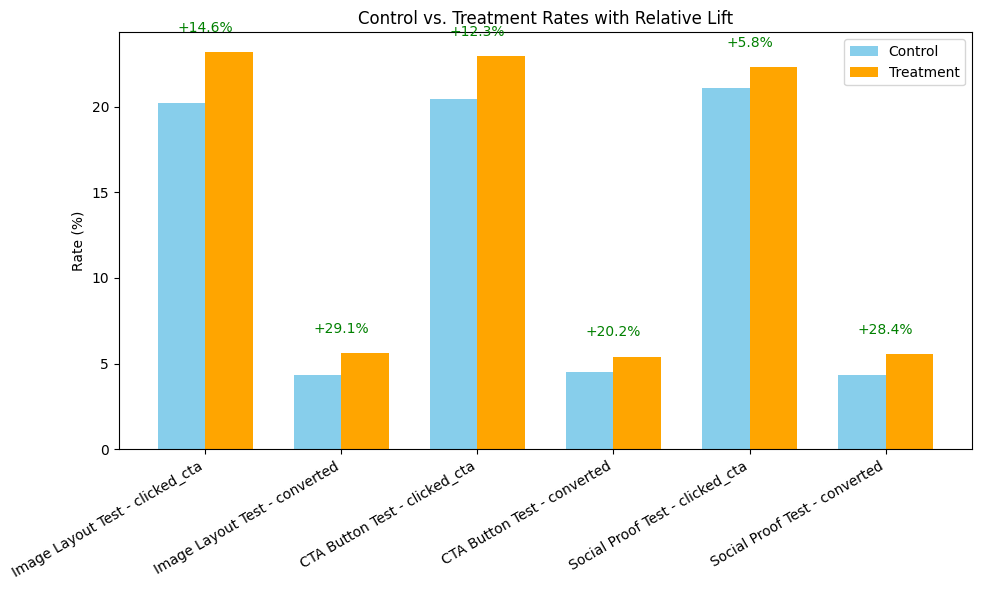

In [ ]:
data = [
    # Test, Metric, Control Rate, Treatment Rate, Relative Lift (%)
    ['Image Layout Test', 'clicked_cta', 20.215, 23.170, 14.62],
    ['Image Layout Test', 'converted', 4.335, 5.598, 29.15],
    ['CTA Button Test', 'clicked_cta', 20.429, 22.947, 12.32],
    ['CTA Button Test', 'converted', 4.510, 5.419, 20.17],
    ['Social Proof Test', 'clicked_cta', 21.073, 22.297, 5.81],
    ['Social Proof Test', 'converted', 4.345, 5.580, 28.42],
]

df = pd.DataFrame(data, columns=['Test', 'Metric', 'Control Rate', 'Treatment Rate', 'Relative Lift'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df))
width = 0.35

bars1 = ax.bar(x - width/2, df['Control Rate'], width, label='Control', color='skyblue')
bars2 = ax.bar(x + width/2, df['Treatment Rate'], width, label='Treatment', color='orange')

# Annotate relative lift
for i, lift in enumerate(df['Relative Lift']):
    ax.text(x[i], max(df['Control Rate'][i], df['Treatment Rate'][i]) + 1, f'+{lift:.1f}%', ha='center', va='bottom', fontsize=10, color='green')

ax.set_xticks(x)
ax.set_xticklabels([f"{row['Test']} - {row['Metric']}" for _, row in df.iterrows()], rotation=30, ha='right')
ax.set_ylabel('Rate (%)')
ax.set_title('Control vs. Treatment Rates with Relative Lift')
ax.legend()
plt.tight_layout()
plt.show()


All the three experiments - Image Layout, CTA Button and Social Proof show consistent improvement in both CTA clicks and conversions. Thus, implmenting these changes can boost the overall productivity in the website.

### Bayesian Credible Intervals for Expected Lift

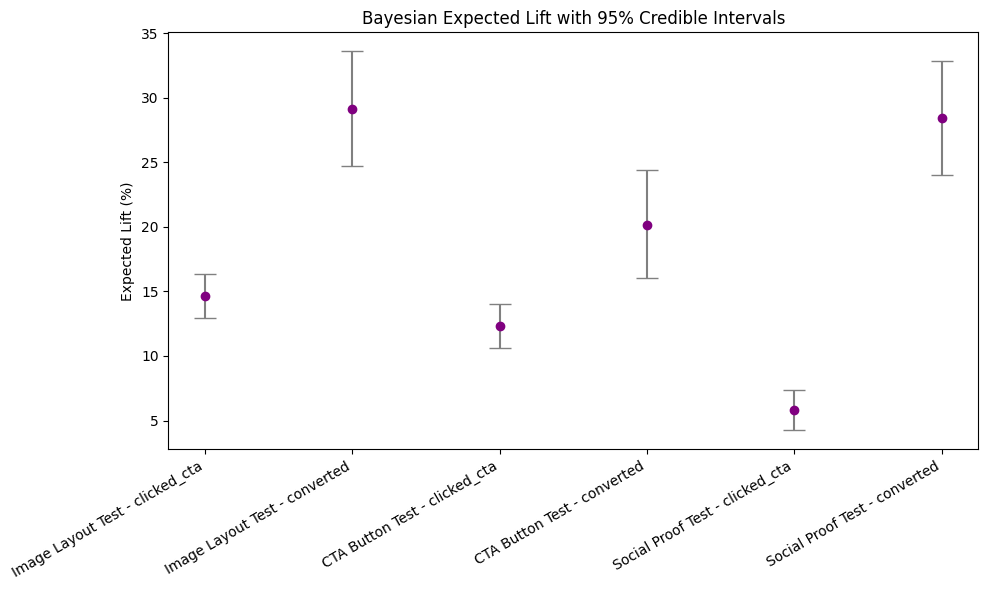

In [ ]:
# Bayesian results data
bayes_data = [
    # Test, Metric, Expected Lift (%), 95% CI Lower, 95% CI Upper
    ['Image Layout Test', 'clicked_cta', 14.64, 12.91, 16.37],
    ['Image Layout Test', 'converted', 29.15, 24.74, 33.61],
    ['CTA Button Test', 'clicked_cta', 12.32, 10.62, 14.01],
    ['CTA Button Test', 'converted', 20.17, 16.07, 24.39],
    ['Social Proof Test', 'clicked_cta', 5.81, 4.23, 7.36],
    ['Social Proof Test', 'converted', 28.43, 24.04, 32.88],
]

bayes_df = pd.DataFrame(bayes_data, columns=['Test', 'Metric', 'Expected Lift', 'CI Lower', 'CI Upper'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(bayes_df))
expected = bayes_df['Expected Lift']
err_lower = expected - bayes_df['CI Lower']
err_upper = bayes_df['CI Upper'] - expected

ax.errorbar(x, expected, yerr=[err_lower, err_upper], fmt='o', capsize=8, color='purple', ecolor='gray')
ax.set_xticks(x)
ax.set_xticklabels([f"{row['Test']} - {row['Metric']}" for _, row in bayes_df.iterrows()], rotation=30, ha='right')
ax.set_ylabel('Expected Lift (%)')
ax.set_title('Bayesian Expected Lift with 95% Credible Intervals')
plt.tight_layout()
plt.show()


The conversion rates show greater confidence compared to the clicked-CTA rates in each of the three experiments. The conversion rates show higher lift than the CTA click rates in each.

For conversion improvements, we need to prioritize Image Layout Test and Social Proof. For CTA clicks, the Image Layout and CTA Button tests are more effective.

### Multiple Testing Correction: Raw vs FDR-Adjusted P-values

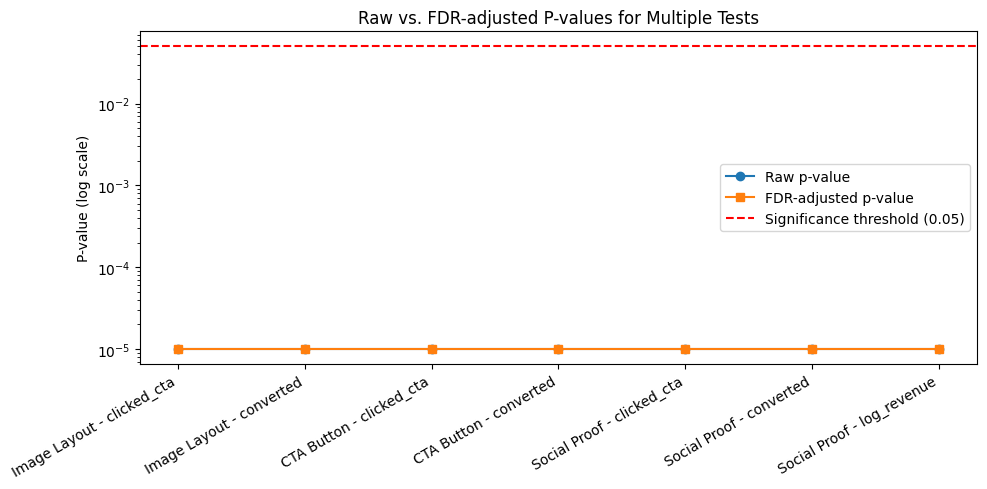

In [ ]:
raw_pvals = np.array([0.0000]*7)  # All reported as 0.0000; use a small value for plotting
fdr_pvals = np.array([0.0000]*7)

# For plotting, use a small value for 0.0000 to show on log scale
plot_pvals = np.where(raw_pvals == 0, 1e-5, raw_pvals)
plot_fdr = np.where(fdr_pvals == 0, 1e-5, fdr_pvals)

labels = [
    'Image Layout - clicked_cta', 'Image Layout - converted',
    'CTA Button - clicked_cta', 'CTA Button - converted',
    'Social Proof - clicked_cta', 'Social Proof - converted',
    'Social Proof - log_revenue'
]

plt.figure(figsize=(10, 5))
plt.plot(labels, plot_pvals, 'o-', label='Raw p-value')
plt.plot(labels, plot_fdr, 's-', label='FDR-adjusted p-value')
plt.axhline(0.05, color='red', linestyle='--', label='Significance threshold (0.05)')
plt.yscale('log')
plt.ylabel('P-value (log scale)')
plt.title('Raw vs. FDR-adjusted P-values for Multiple Tests')
plt.xticks(rotation=30, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


As the p-values for both raw and FDR-adjusted are extremely low and smaller than 0.05 (significance threshold); all tests are statistically significant. It is a proof for genuine effects on the metrics tested (conversion and click-through rates) due to the experimental changes. Thus, the observed lifts are real effect and not random noise.

### Lift Distribution

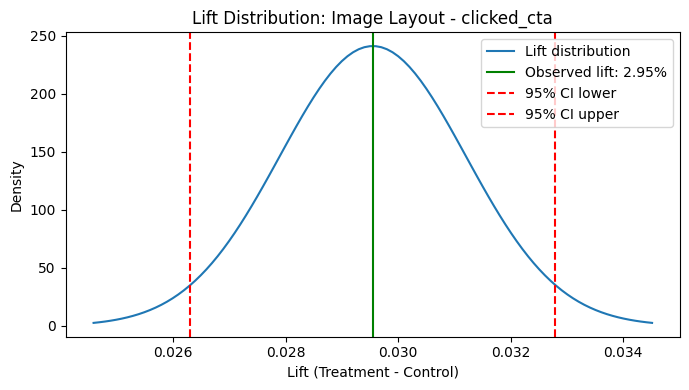

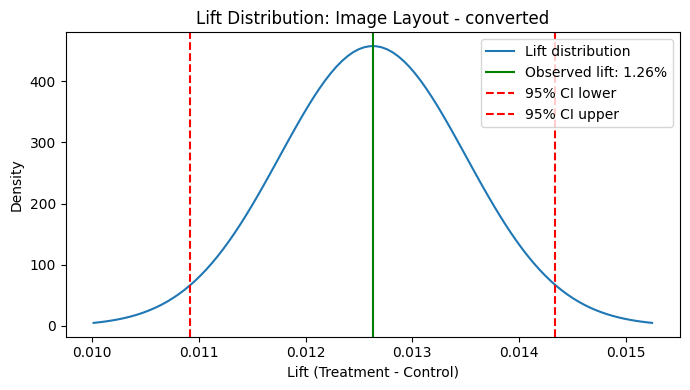

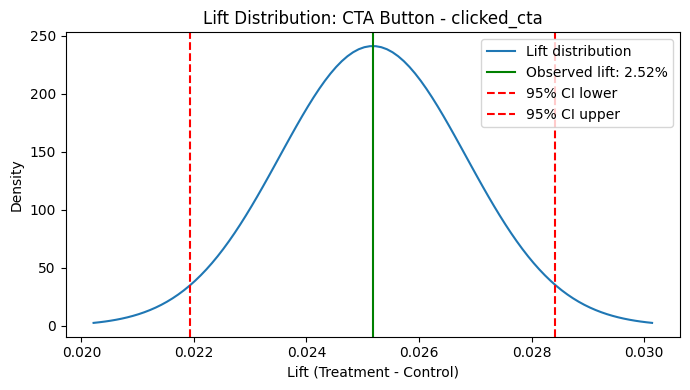

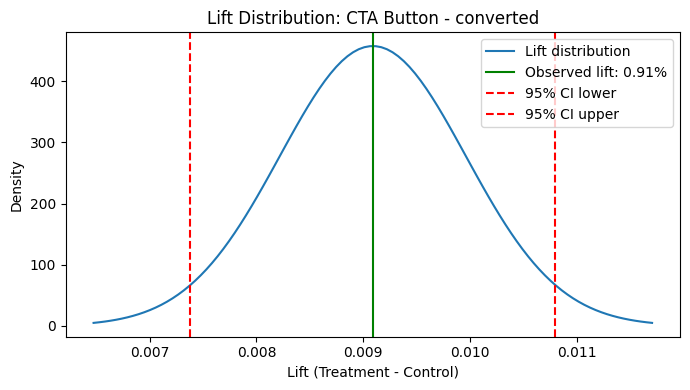

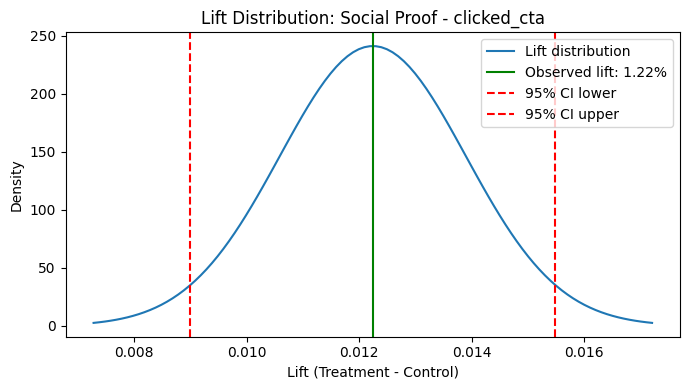

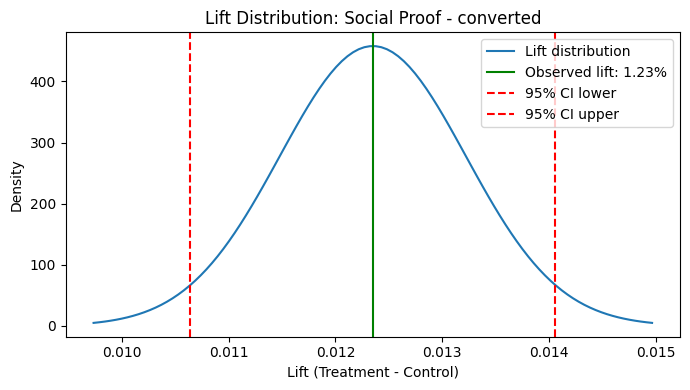

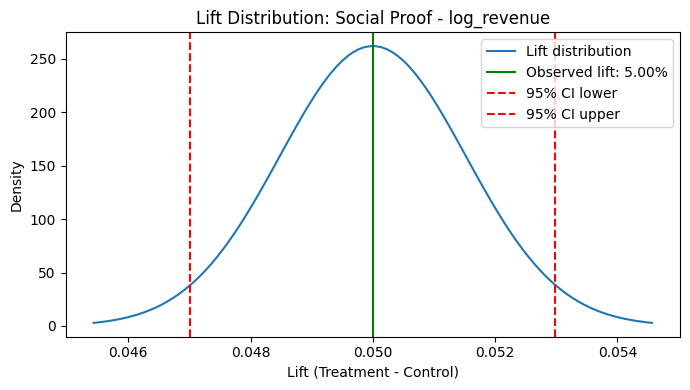

In [ ]:
metrics = [
    # (Label, control_rate/mean, n_control, treatment_rate/mean, n_treatment)
    ('Image Layout - clicked_cta', 0.20215, 124418, 0.23170, 123615),
    ('Image Layout - converted', 0.04335, 124418, 0.05598, 123615),
    ('CTA Button - clicked_cta', 0.20429, 124068, 0.22947, 123965),
    ('CTA Button - converted', 0.04510, 124068, 0.05419, 123965),
    ('Social Proof - clicked_cta', 0.21073, 123597, 0.22297, 124436),
    ('Social Proof - converted', 0.04345, 123597, 0.05580, 124436),
    # For log_revenue, treat as means, not proportions
    ('Social Proof - log_revenue', 0.15, 123597, 0.20, 124436)
]

for label, control, n_control, treatment, n_treatment in metrics:
    # Calculate lift and standard deviation
    lift_mean = treatment - control
    # For proportions (conversion rates), use binomial variance; for means, use normal approx (here, assume variance unknown, so use proportions formula for all)
    cont_var = control * (1 - control) / n_control
    treat_var = treatment * (1 - treatment) / n_treatment
    lift_sd = np.sqrt(cont_var + treat_var)
    # 95% confidence interval
    lwr_ci = lift_mean - 1.96 * lift_sd
    upr_ci = lift_mean + 1.96 * lift_sd

    # Generate x-values for the normal distribution
    lift_line = np.linspace(lift_mean - 3 * lift_sd, lift_mean + 3 * lift_sd, 100)
    plt.figure(figsize=(7, 4))
    plt.plot(lift_line, norm.pdf(lift_line, lift_mean, lift_sd), label='Lift distribution')
    plt.axvline(x=lift_mean, color='green', label=f'Observed lift: {lift_mean*100:.2f}%')
    plt.axvline(x=lwr_ci, color='red', linestyle='--', label='95% CI lower')
    plt.axvline(x=upr_ci, color='red', linestyle='--', label='95% CI upper')
    plt.title(f'Lift Distribution: {label}')
    plt.xlabel('Lift (Treatment - Control)')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


The above charts show the statistical distribution of the lift in clicked CTA rate and conversion rate due to the three experiments - image layout, CTA button and social proof respectively. The lift distribution has a bell-shaped curve, which signifies normal distribution of the values.

## **Segmentation Analysis**

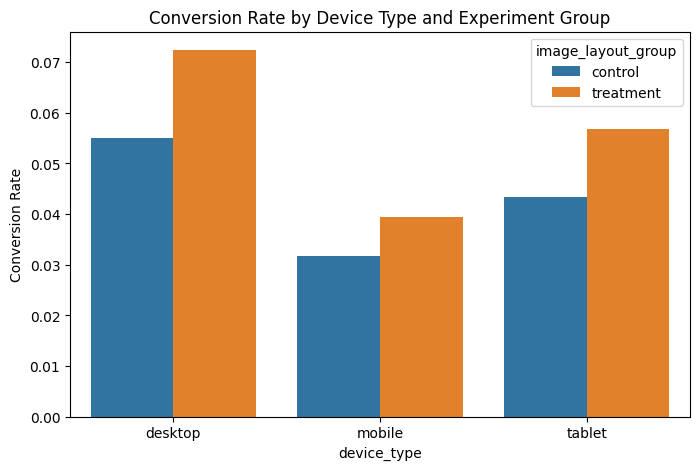

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Conversion rate by device type and experiment group
seg_device = sessions_df.groupby(['device_type', 'image_layout_group']).agg(
    sessions=('session_id', 'count'),
    conversions=('converted', 'sum')
).reset_index()
seg_device['conversion_rate'] = seg_device['conversions'] / seg_device['sessions']

plt.figure(figsize=(8, 5))
sns.barplot(data=seg_device, x='device_type', y='conversion_rate', hue='image_layout_group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Device Type and Experiment Group')
plt.show()


The result of image layout test is seen to be consistently better in the treatment group over the control group across all the device types - desktop, mobile and tablet.

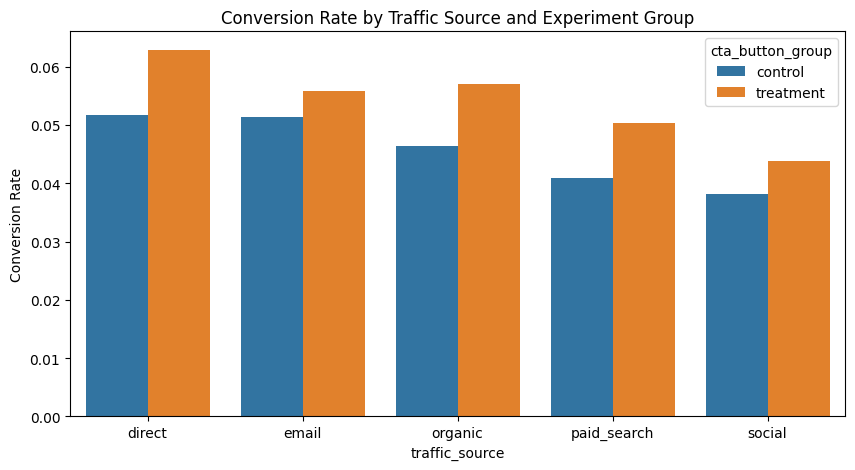

In [ ]:
seg_source = sessions_df.groupby(['traffic_source', 'cta_button_group']).agg(
    sessions=('session_id', 'count'),
    conversions=('converted', 'sum')
).reset_index()
seg_source['conversion_rate'] = seg_source['conversions'] / seg_source['sessions']

plt.figure(figsize=(10, 5))
sns.barplot(data=seg_source, x='traffic_source', y='conversion_rate', hue='cta_button_group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Traffic Source and Experiment Group')
plt.show()


The CTA button test is proved effective for the treatment group across all the traffic sources - direct, email, organic, paid search and social.

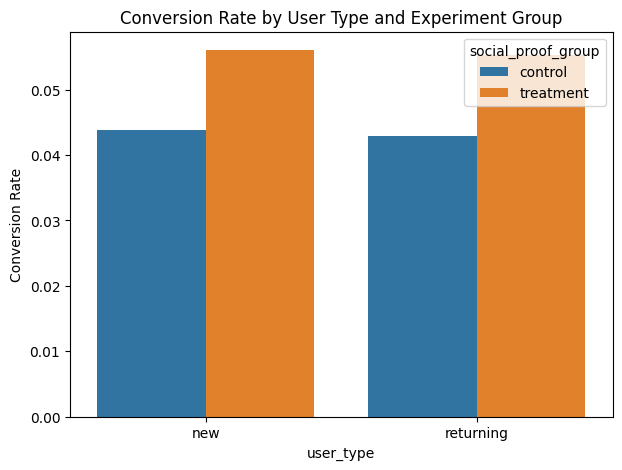

In [ ]:
seg_user = sessions_df.groupby(['user_type', 'social_proof_group']).agg(
    sessions=('session_id', 'count'),
    conversions=('converted', 'sum')
).reset_index()
seg_user['conversion_rate'] = seg_user['conversions'] / seg_user['sessions']

plt.figure(figsize=(7, 5))
sns.barplot(data=seg_user, x='user_type', y='conversion_rate', hue='social_proof_group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by User Type and Experiment Group')
plt.show()


The social proof test is effective for both new and returning users.

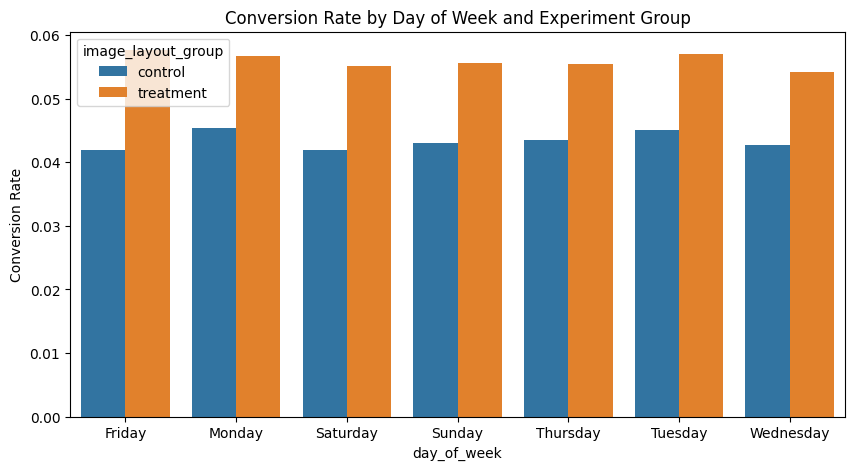

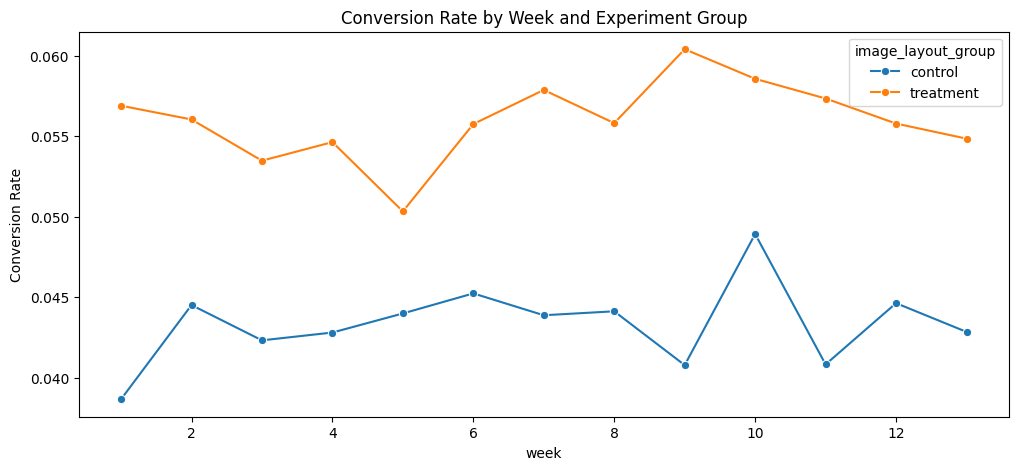

In [ ]:
# By day of week
seg_day = sessions_df.groupby(['day_of_week', 'image_layout_group']).agg(
    sessions=('session_id', 'count'),
    conversions=('converted', 'sum')
).reset_index()
seg_day['conversion_rate'] = seg_day['conversions'] / seg_day['sessions']

plt.figure(figsize=(10, 5))
sns.barplot(data=seg_day, x='day_of_week', y='conversion_rate', hue='image_layout_group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Day of Week and Experiment Group')
plt.show()

# By week number
seg_week = sessions_df.groupby(['week', 'image_layout_group']).agg(
    sessions=('session_id', 'count'),
    conversions=('converted', 'sum')
).reset_index()
seg_week['conversion_rate'] = seg_week['conversions'] / seg_week['sessions']

plt.figure(figsize=(12, 5))
sns.lineplot(data=seg_week, x='week', y='conversion_rate', hue='image_layout_group', marker='o')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Week and Experiment Group')
plt.show()


The conversion rates across the days of the week as well as across the various weeks are higher for the treatment group compared to the control group. This demonstrates the effectiveness of our results over time.

## **Cohort Analysis**

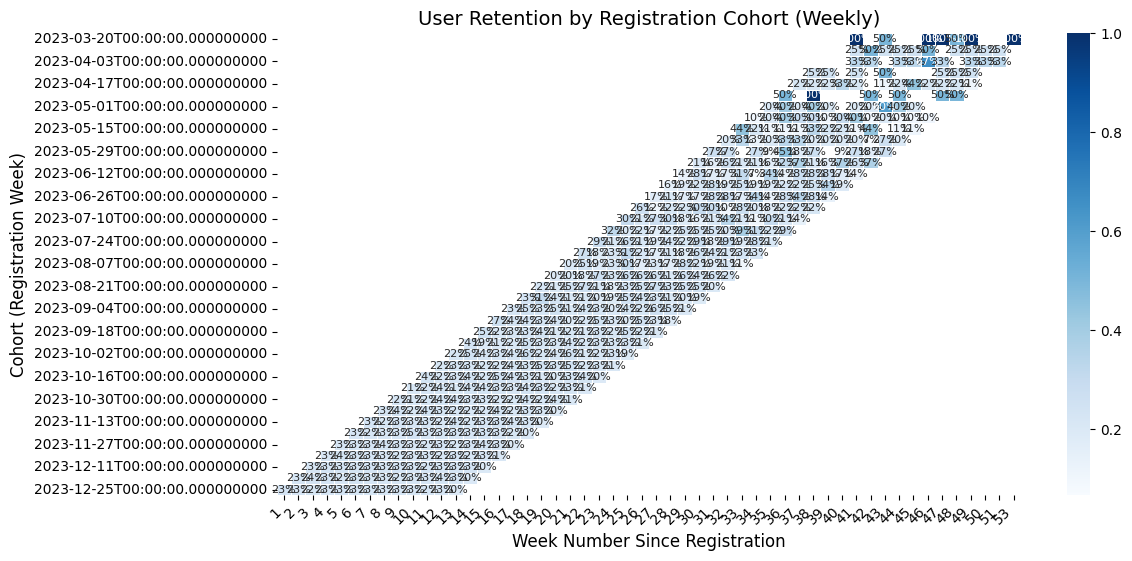

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure registration_date and session_date are datetime
users_df['registration_date'] = pd.to_datetime(users_df['registration_date'])
sessions_df['session_date'] = pd.to_datetime(sessions_df['session_date'])

# Assign cohort: registration week
users_df['cohort_week'] = users_df['registration_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Merge cohort info into sessions
sessions_df = sessions_df.merge(users_df[['user_id', 'cohort_week']], on='user_id', how='left')
sessions_df['session_week'] = sessions_df['session_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Retention: Unique users per cohort per week
cohort_data = sessions_df.groupby(['cohort_week', 'session_week'])['user_id'].nunique().reset_index()
cohort_sizes = users_df.groupby('cohort_week')['user_id'].nunique()
cohort_data = cohort_data.merge(cohort_sizes, on='cohort_week', suffixes=('', '_cohort_size'))
cohort_data['period_number'] = ((cohort_data['session_week'] - cohort_data['cohort_week']).dt.days // 7)
cohort_data['retention'] = cohort_data['user_id'] / cohort_data['user_id_cohort_size']

# Pivot for heatmap
cohort_pivot = cohort_data.pivot(index='cohort_week', columns='period_number', values='retention')

plt.figure(figsize=(12, 6))
sns.heatmap(cohort_pivot, annot=True, fmt='.0%', cmap='Blues', annot_kws ={"size":8}, linewidths = 0.5, linecolor = 'white')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title('User Retention by Registration Cohort (Weekly)', fontsize = 14)
plt.xlabel('Week Number Since Registration', fontsize = 12)
plt.ylabel('Cohort (Registration Week)', fontsize = 12)
plt.show()
# Calculate cohort sizes and rename
cohort_sizes = users_df.groupby('cohort_week')['user_id'].nunique().reset_index()
cohort_sizes.rename(columns={'user_id': 'user_id_cohort_size'}, inplace=True)

# Merge cohort sizes into cohort_data
cohort_data = cohort_data.merge(cohort_sizes, on='cohort_week', how='left')


The cohort analysis of the data shows us that users drop off after initial registration. However, it stabilizes around 23 to 25 percentage.

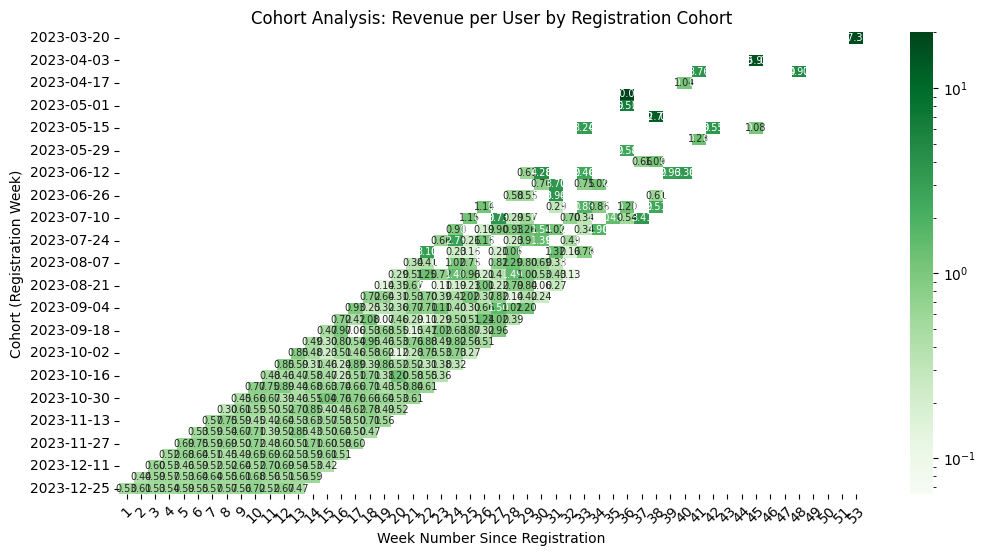

In [ ]:

from matplotlib.colors import LogNorm

# Cumulative revenue per user per week since registration
revenue_data = sessions_df.groupby(['cohort_week', 'session_week'])['revenue'].sum().reset_index()
revenue_data = revenue_data.merge(cohort_sizes, on='cohort_week', suffixes=('', '_cohort_size'))
revenue_data['period_number'] = ((revenue_data['session_week'] - revenue_data['cohort_week']).dt.days // 7)
revenue_data['revenue_per_user'] = revenue_data['revenue'] / revenue_data['user_id_cohort_size']

# Pivot for heatmap
revenue_pivot = revenue_data.pivot(index='cohort_week', columns='period_number', values='revenue_per_user')
revenue_pivot.index = revenue_pivot.index.strftime('%Y-%m-%d')

plt.figure(figsize=(12, 6))
sns.heatmap(revenue_pivot, annot=True, fmt='.2f', cmap='Greens', annot_kws ={"size":7}, norm = LogNorm())
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.title('Cohort Analysis: Revenue per User by Registration Cohort')
plt.xlabel('Week Number Since Registration')
plt.ylabel('Cohort (Registration Week)')
plt.show()


Early cohorts shows high revenue on occasional instances. The revenue per user later stabilizes. Only a few users spend on the higher side, most users spend an average amount on the website.